In [1]:
TRAIN_CSV_FILE = "train.csv"
TEST_CSV_FILE = "test.csv"


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    genres = '1 2 3 4 5 6 7 8 9 0'.split()
    for filename in os.listdir(soundFilesFolder):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        #file = open('data.csv', 'a', newline='')
        #with file:
        #    writer = csv.writer(file)
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

# comment these lines if you already have train.csv and test.csv files
#extractWavFeatures("../data/recordings/train", TRAIN_CSV_FILE)
#extractWavFeatures("../data/recordings/test", TEST_CSV_FILE)


In [3]:
#Reading a dataset and convert file name to corresbonding umnber

import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName)
    data['number'] = data['filename'].str[:1]
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data

trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)


train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.112672         741.829081          758.492178  1438.494873   
1  0.090344         635.610880          670.336296  1160.452403   
2  0.091456         667.786694          732.606545  1257.180176   
3  0.087751         712.304185          731.292437  1449.104818   
4  0.096603         844.363886          777.868127  1569.583263   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.034023 -295.578461  189.853683 -19.606564   6.078507   
1            0.033458 -339.148743  204.005249  -7.485526  14.297898   
2            0.033268 -327.507416  195.596924  -3.994768  21.315840   
3            0.035916 -320.809937  200.023743  -8.186146  12.661074   
4            0.049465 -315.801300  195.674118 -13.324564   3.544238   

       mfcc5  ...     mfcc12    mfcc13     mfcc14     mfcc15    mfcc16  \
0  22.067095  ... -25.725817 -5.172223 

In [4]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)


X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(1029,)
(441,)
(30,)


In [5]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(1029, 25)
(441, 25)
(30, 25)


In [6]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))



Using TensorFlow backend.


In [7]:
# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [9]:
#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])



Train on 1029 samples, validate on 441 samples
Epoch 1/50
1029/1029 [==============================] - 0s 142us/step - loss: 2.1299 - accuracy: 0.2828 - val_loss: 1.8192 - val_accuracy: 0.5034
Epoch 2/50
1029/1029 [==============================] - 0s 29us/step - loss: 1.6446 - accuracy: 0.5316 - val_loss: 1.3902 - val_accuracy: 0.6531
Epoch 3/50
1029/1029 [==============================] - 0s 30us/step - loss: 1.3049 - accuracy: 0.5948 - val_loss: 1.0434 - val_accuracy: 0.7029
Epoch 4/50
1029/1029 [==============================] - 0s 30us/step - loss: 1.0669 - accuracy: 0.6667 - val_loss: 0.7961 - val_accuracy: 0.8458
Epoch 5/50
1029/1029 [==============================] - 0s 26us/step - loss: 0.8518 - accuracy: 0.7434 - val_loss: 0.6217 - val_accuracy: 0.8844
Epoch 6/50
1029/1029 [==============================] - 0s 28us/step - loss: 0.6943 - accuracy: 0.7959 - val_loss: 0.4795 - val_accuracy: 0.9138
Epoch 7/50
1029/1029 [==============================] - 0s 30us/step - loss: 0.591

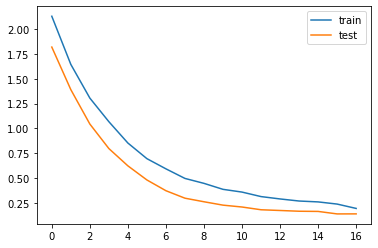

In [10]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Predection 
print('\n# Generate predictions for 3 samples')

print("y[0]: "+ y_test[0])
print("y[10]: "+ y_test[10])
print("y[20]: "+ y_test[20])

print(model.predict(X_test[0:1]))
print(model.predict(X_test[10:11]))
print(model.predict(X_test[20:21]))


30/30 [==============================] - 0s 67us/step
accuracy: 96.67%

# Generate predictions for 3 samples
y[0]: 0
y[10]: 3
y[20]: 6
[[9.9036926e-01 3.8926762e-03 7.1987219e-04 1.1333391e-03 1.2376405e-03
  6.0226495e-05 6.2944280e-04 8.9336827e-05 2.4185117e-04 1.6263069e-03]]
[[2.5289545e-03 2.0316807e-03 1.3872304e-02 9.0978491e-01 6.5767032e-04
  2.9381029e-03 5.4688781e-02 5.7145027e-03 4.2872592e-03 3.4958150e-03]]
[[5.0491708e-05 1.2936530e-04 2.1745465e-03 5.3086993e-03 1.6938520e-04
  5.5092340e-04 9.8376542e-01 6.4861025e-03 1.0918276e-03 2.7327178e-04]]
